In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

#신경망 가중치와 결과의 무작위성을 줄이기 위해 랜덤 시드를 설정
#결과를 완전히 재현하는 것은 여전히 어려울 수 있음

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# combined_faces 압축 파일 풀기

combined_faces_zip_path = "/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/age/1.1_age_input_output/input/combined_faces.zip"
extracted_path='/content/combined_faces'
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall(extracted_path)
    print('Done unzipping combined_faces.zip')

In [ ]:
# combined_faces 압축 파일 풀기

combined_faces_zip_path = "/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/age/combined_faces_train_augmented-002.zip"
extracted_path='/content/combined_faces'
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall(extracted_path)
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [ ]:
# 증강된 데이터셋 블러와서 텐서 만들기

train_aug_df = pd.read_csv("/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/age/1.1_age_input_output/input/images_filenames_labels_train_augmented_1.csv")
test_df = pd.read_csv("/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/age/1.1_age_input_output/input/images_filenames_labels_test_1.csv")

In [ ]:
# 나이 범주별 라벨링

def class_labels_reassign(age):

    if 1 <= age <= 5:
        return 0
    elif 6<= age <= 10:
        return 1
    elif 11 <= age <= 15:
        return 2
    elif 16 <= age <=20:
        return 3
    elif 21 <= age <= 26:
        return 4
    elif 27 <= age <= 32:
        return 5
    elif 33 <= age <= 39:
        return 6
    elif 40 <= age <= 48:
        return 7
    elif 49 <= age <= 56:
        return 8
    elif 57 <= age <= 65:
        return 9
    else:
        return 10

In [ ]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [ ]:
# 증강된 훈련,검증 데이터셋들을 위해 파일 이름과 타겟 클래스 라벨 변경

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [ ]:
# 위에서 정의한 목록들을 사용하여 증강된(데이터를 늘린) 학습 및 테스트 데이터셋에 대한 TensorFlow 상수를 만들고, 파일 이름과 레이블을 나타내기

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

Image Greyscale Function

In [ ]:
# 주어진 텐서로부터 이미지를 읽고, 이미지를 해독하며, 이미지 레이블 클래스를 원-핫 인코딩하는 함수 정의.
# tf.io.decode_jpeg에서 channels 매개변수를 3에서 1로 변경하면 출력 이미지가 RGB 색상이 아닌 그레이스케일로 변함

num_classes = 11

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 그레이 스케일로 바꾸기 위해서, channels=3 RGB로 바꾸기 위해서.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [ ]:
# 뉴런 네트워크를 위해 데이터셋 가져오기
# 위에서 정의한 텐서 벡터를 사용하여 데이터셋에서 이미지에 접근하고, 위에서 정의한 함수를 통해 이미지를 처리

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # 아래 model.fit()에서의 batch_size 하이퍼파라미터와 동일

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # 아래 model.fit()에서의 batch_size 하이퍼파라미터와 동일

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

# VGG-16 모델 정의
vgg16_model = Sequential()

# 첫 번째 블록
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 1)))
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

# 두 번째 블록
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

# 세 번째 블록
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
vgg16_model.add(GlobalAveragePooling2D())

# 완전히 연결된 레이어
vgg16_model.add(Dense(4096, activation='relu'))
vgg16_model.add(Dense(4096, activation='relu'))

# 출력 레이어
vgg16_model.add(Dense(11, activation='softmax'))

# VGG16 모델 요약본 출력
vgg16_model.()summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 128)       0         
 g2D)                                                   

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 콜백 형성 (텐서보드와 체크포인트)
tensorboard = TensorBoard(log_dir='logs/')
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# VGG-16 모델 컴파일
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# VGG-16 모델 학습
vgg16_history = vgg16_model.fit(train_aug_dataset,
                                batch_size=512,
                                validation_data=test_dataset,
                                epochs=30,
                                callbacks=[tensorboard, checkpoint],
                                shuffle=False  # shuffle=False를 사용하여 무작위성을 줄이고 재현성 높이기
                               )

Epoch 1/30
458/458 [==============================] - ETA: 0s - loss: 2.2606 - accuracy: 0.2229

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


458/458 [==============================] - 322s 617ms/step - loss: 2.2606 - accuracy: 0.2229 - val_loss: 2.1061 - val_accuracy: 0.2673
Epoch 2/30
458/458 [==============================] - 256s 559ms/step - loss: 2.0171 - accuracy: 0.2894 - val_loss: 1.8176 - val_accuracy: 0.3455
Epoch 3/30
458/458 [==============================] - 256s 558ms/step - loss: 1.6840 - accuracy: 0.3762 - val_loss: 1.5334 - val_accuracy: 0.4162
Epoch 4/30
458/458 [==============================] - 256s 559ms/step - loss: 1.4687 - accuracy: 0.4328 - val_loss: 1.3909 - val_accuracy: 0.4567
Epoch 5/30
458/458 [==============================] - 256s 559ms/step - loss: 1.3389 - accuracy: 0.4721 - val_loss: 1.3320 - val_accuracy: 0.4849
Epoch 6/30
458/458 [==============================] - 256s 559ms/step - loss: 1.2392 - accuracy: 0.5052 - val_loss: 1.2629 - val_accuracy: 0.5109
Epoch 7/30
458/458 [==============================] - 256s 559ms/step - loss: 1.1433 - accuracy: 0.5431 - val_loss: 1.1740 - val_accura

In [ ]:
# 위에서 정의한 신경망에서 학습 및 테스트 손실 및 정확도 값 확인

train_loss = vgg16_history.history['loss']
test_loss = vgg16_history.history['val_loss']
train_accuracy = vgg16_history.history['accuracy']
test_accuracy = vgg16_history.history['val_accuracy']

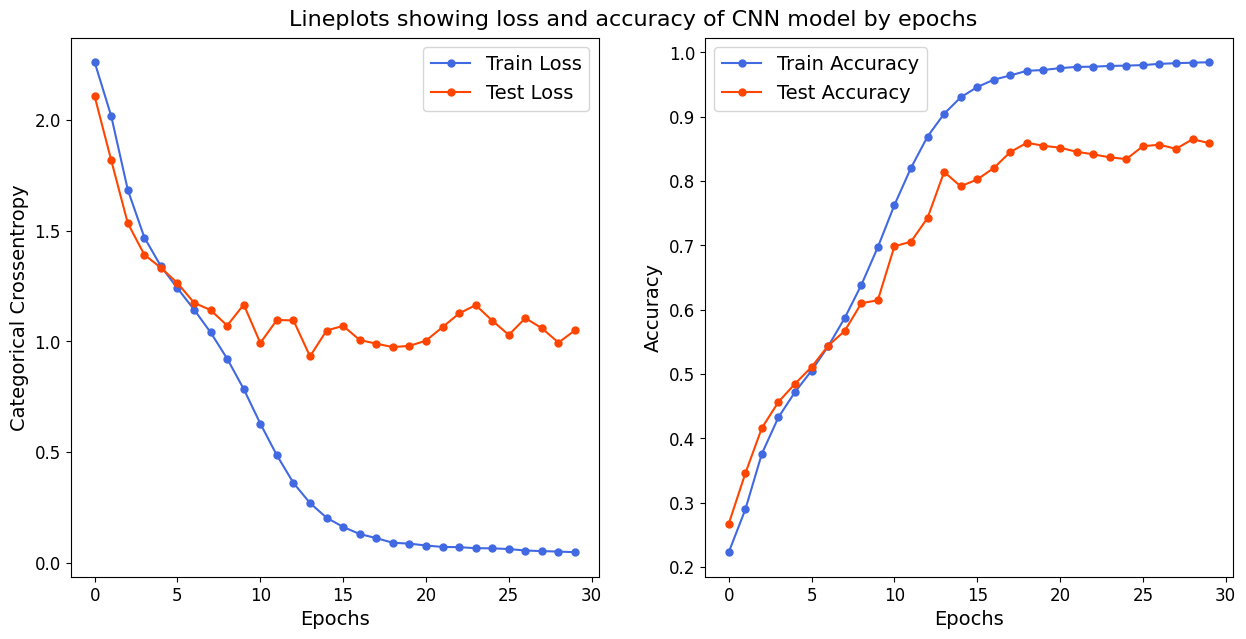

In [ ]:
# 에포크별로 손실과 정확도 값을 시각화하기 위해 선 그래프 그림.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# PNG 형식으로 그래프 이미지를 출력
plt.savefig('/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/third_final_vgg16_loss_accuracy.png', bbox_inches='tight');

In [ ]:
# 테스트 데이터셋에서 모델 평가

final_vgg16_score = vgg16_model.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 3s 167ms/step - loss: 1.0498 - accuracy: 0.8589


In [ ]:
# 관련된 점수 요약 출력.

final_vgg16_labels = vgg16_model.metrics_names
print(f'CNN model {final_vgg16_labels[0]} \t\t= {round(final_vgg16_score[0], 3)}')
print(f'CNN model {final_vgg16_labels[1]} \t= {round(final_vgg16_score[1], 3)}')

CNN model loss 		= 1.05
CNN model accuracy 	= 0.859


In [ ]:
# 모델을 나중에 사용할 수 있도록 h5 파일로 저장.

vgg16_model.save(f"/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/third_age_model_acc_{round(final_vgg16_score[1], 3)}.h5", save_format='h5')

In [ ]:
# 위의 모델로부터 예측 생성

final_vgg16_pred = vgg16_model.predict(test_dataset)
final_vgg16_pred = final_vgg16_pred.argmax(axis=-1)

20/20 [==============================] - 3s 170ms/step


In [ ]:
# 위의 예측을 기반으로 혼동 행렬(Confusion Matrix) 생성.

conf_mat = confusion_matrix(test_labels_list, final_vgg16_pred)
conf_mat

array([[1379,    5,    1,    0,    5,    5,    4,    0,    2,    1,    0],
       [  20,  434,   13,    7,   18,    4,    2,    1,    0,    0,    0],
       [   5,   15,  273,   12,    6,    5,    4,    0,    1,    0,    1],
       [   0,    1,    7,  463,   26,   16,    4,    1,    3,    0,    0],
       [   3,    1,    3,   25, 1554,  134,   37,   12,    5,    4,    2],
       [   3,    5,    1,   10,  140, 1147,   41,   11,   13,    5,    3],
       [   4,    3,    1,    5,   80,   64,  853,   22,   22,    3,    2],
       [   0,    1,    0,    5,   40,   63,   41,  588,   36,   18,    5],
       [   2,    2,    2,    2,   25,   18,   27,   22,  705,   29,   17],
       [   2,    0,    2,    2,    5,    6,   13,   11,   39,  514,   33],
       [   3,    3,    1,    0,    2,    3,    2,   10,   24,   42,  719]])

In [ ]:
# 보다 쉬운 시각화를 위해 혼동 행렬을 그리기 위한 함수 정의.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # PNG 형식으로 그래프 이미지 내보내기.
    plt.savefig(f'/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


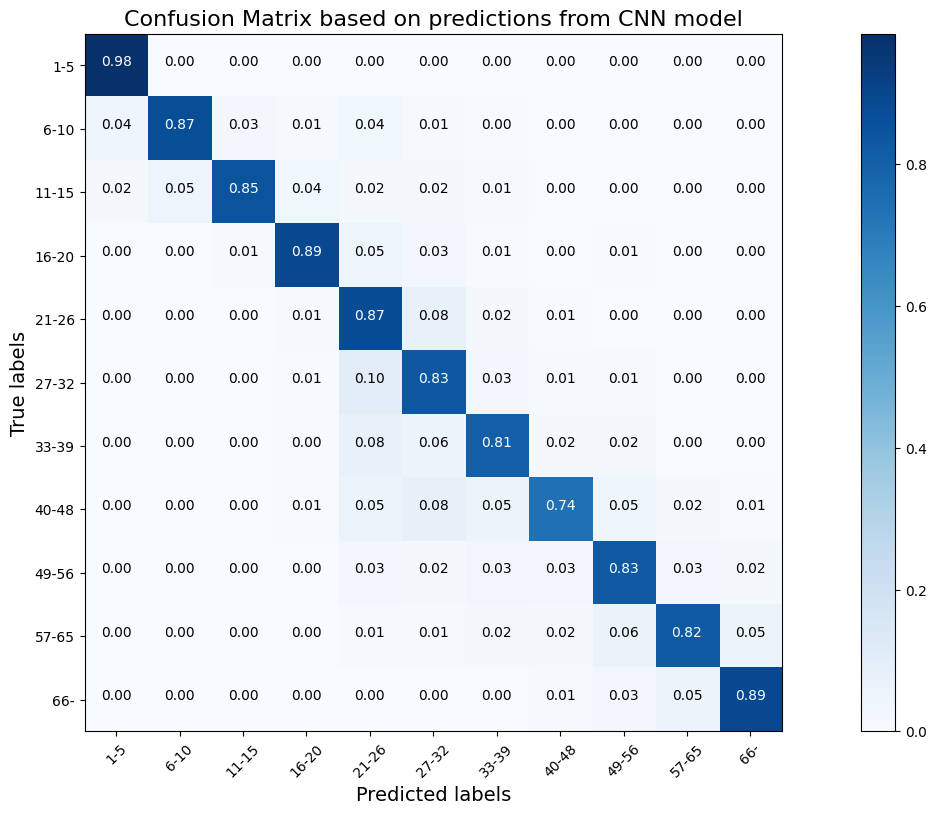

In [ ]:
# 위에서 정의한 함수를 사용하여 혼동 행렬 그리기.

cm_plot_labels = ['1-5', '6-10', '11-15', '16-20', '21-26', '27-32', '33-39','40-48','49-56','57-65','66-']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()